### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

import statmorph
import time

### 1. Load the all-in-one data

In [2]:
all_gals = pickle.load(open("../../bf_data/Nair_and_Abraham_2010/all_gals.pickle", "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

### Issue: TMO is dependent on the absolute value of a image 

Use fraction rather than absolute value??  
Or, set a *global* constraint? (maybe it makes sense bc values in all images are consistent in physical meaning)

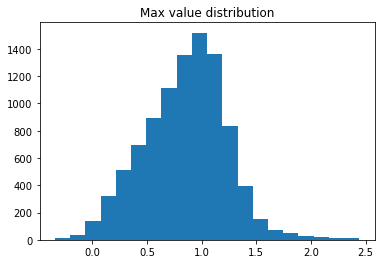

In [3]:
# See how the maximum values of the images distribute.
maxes = [gal['data'][0].max() for gal in all_gals]
plt.hist(np.log10(maxes), bins=20)
plt.title("Max value distribution")
plt.show()
# 

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [27]:
from astrobf.utils.misc import load_Nair
cat = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
#cat = cat[1:]

                         ID      RA    dec  zred  zred_q     mg     mr  Mag_r  \
0      J155341.74-003422.84  238.42  -0.57  0.07    1.00  15.82  15.05 -22.08   
1      J155146.83-000618.62  237.94  -0.10  0.05    1.00  15.51  14.60 -21.56   
2      J154453.22+002415.48  236.22   0.40  0.03    1.00  15.63  14.83 -20.27   
3      J154711.32+002424.81  236.79   0.40  0.03    0.96  15.71  15.15 -20.10   
4      J154514.39+004619.89  236.31   0.77  0.01    1.00  15.34  14.95 -18.38   
...                     ...     ...    ...   ...     ...    ...    ...    ...   
14029  J124719.07+154235.64  191.83  15.71  0.06    1.00  15.78  14.90 -21.85   
14030  J130510.16+152606.67  196.29  15.43  0.05    1.00  15.31  14.59 -21.62   
14031  J131525.21+152522.23  198.85  15.42  0.02    1.00  15.25  14.34 -20.14   
14032  J132045.57+151532.75  200.19  15.26  0.02    0.99  15.72  14.93 -19.32   
14033  J132135.96+151917.80  200.40  15.32  0.02    1.00  15.47  14.80 -19.47   

       logLg  Rpetro   Rp50

In [4]:
all_morphs = glob("../../bf_data/Nair_and_Abraham_2010/BriAda/Morphs/*.pickle")
result_arr = measure_morph.load_initial_morph(all_morphs, good_gids)

print(len(result_arr))

9536


# Initialize BO loop -  Measure morphology features

In [5]:
import torch
import math

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

### Initial guesses 


In [31]:
fields = ['gini', 'm20']#, 'concentration', 'asymmetry', 'smoothness']

from astrobf.utils.misc import struct_to_ndarray, select_columns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, MeanShift, SpectralClustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_clustering(clu, data, labels):
    estimator = make_pipeline(StandardScaler(), clu).fit(data)
    #results = [estimator[-1].inertia_] # Kmeans only.

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results = [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    return results


def add_ttype(result_arr, cat):
    inds = cat['ID'].searchsorted(result_arr['id'])
    print("Is every element matched?: ", np.all(cat[inds]['ID'] == result_arr['id']))
    result_arr['ttype'] = cat[inds]['TT']

def get_binary_label(arr, field, vmin, vmax):
    """
    vmin = minimum of label==1 value
    vmax = maximum of label==1 value
    """
    labels = np.zeros(len(arr), dtype=np.int8)
    ind_positive = np.where((arr['ttype'] >= vmin) * (arr['ttype'] <= vmax))[0]
    print(len(ind_positive))
    labels[ind_positive] = 1 # Zero otherwise
    return labels

def do_ML(result_arr, n_clusters=2, fields=['gini', 'm20', 'concentration'],
          return_cluster=False, cluster_method="ward"):
    compact = struct_to_ndarray(select_columns(result_arr, fields))
    
    # Binary classification 
    #labels = get_binary_label(result_arr, 'ttype', 3, 6)
    print("positive samples {}/{}".format(np.sum(result_arr['ttype']), len(result_arr)))
    
    if cluster_method == "kmeans":
        clustering = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                        random_state=0)
    elif cluster_method == "ward":
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    eval_metrics = bench_clustering(clustering, compact, result_arr['ttype'])
    if not return_cluster:
        return eval_metrics
    else:
        return eval_metrics, clustering

# Run Bayesian Optimization loop

In [14]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient
#from ax.utils.notebook.plotting import render, init_notebook_plotting
#init_notebook_plotting()

### define evaluation function
1. Measure Morphological parameters 
2. cluster/classify 
3. assess clustering/classification


In [36]:
from astrobf.morph import custom_morph

def evaluate(params, cluster_method="ward"):
    #result_arr = custom_morph.step_simple_morph(all_gals, params)
    fields = ['gini', 'm20']
    result_arr = np.zeros(len(all_gals), 
                      dtype=[('id','<U24'),('ttype',int)]
                           +[(ff,float) for ff in fields])
    add_ttype(result_arr, cat)
    labels = get_binary_label(result_arr, 'ttype', 3, 7)
    result_arr['ttype'] = labels
    print(np.sum(result_arr['ttype']))
    print(labels)
    
    result_arr = custom_morph.step_simple_morph_dual(all_gals, result_arr, params)
    if result_arr[0] == "bad":
        #print(result_arr)
        return {"mymetric": (-1, 0), "total_flux":(result_arr[1],0)}
    
    eval_metrics = do_ML(result_arr, fields=['gini', 'm20'], cluster_method='ward')
    silhouette_score = eval_metrics[-1]
    stderr = 0.0
    return {"mymetric": (silhouette_score, stderr), "total_flux":(1,0)}

In [39]:
fields = ['gini', 'm20']
result_arr = np.zeros(len(all_gals), 
                  dtype=[('id','<U24'),('ttype',int)]
                       +[(ff,float) for ff in fields])
add_ttype(result_arr, cat)

Is every element matched?:  False


(array([    0.,     0.,     0.,     0.,     0.,  9536.,     0.,     0.,
            0.,     0.]),
 array([ 7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5]),
 <BarContainer object of 10 artists>)

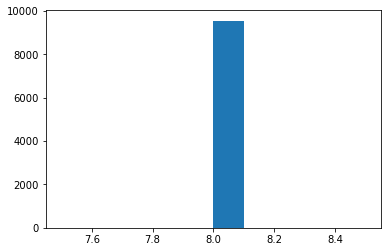

In [43]:
plt.hist(result_arr["ttype"])

In [38]:
evaluate({'b': 1.76, 'c': 4.7, 'dl': 5.99, 'dh': 3.71,
          'b2': 1.76, 'c2': 4.7, 'dl2': 5.99, 'dh2': 3.71})

Is every element matched?:  False
0
0
[0 0 0 ..., 0 0 0]


KeyboardInterrupt: 

In [37]:
import importlib
importlib.reload(custom_morph)

<module 'astrobf.morph.custom_morph' from '/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py'>

In [17]:
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [18]:
ax_client = AxClient()

[INFO 04-14 14:03:39] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [32]:
# 0.45x is the lowest value of maximum flux of all images.
ax_client.create_experiment(
    parameters=[
        {"name": "b",
        "type": "range",
        "bounds": [1.0, 4.0],
        "value_type": "float",  # Optional, defaults to inference from type of "bounds".
        "log_scale": False},
        {"name": "b2",
        "type": "range",
        "bounds": [1.0, 4.0],
        "value_type": "float",  # Optional, defaults to inference from type of "bounds".
        "log_scale": False},
        {"name": "c",
        "type": "range",
        "bounds": [0.5, 5.0]},
        {"name": "c2",
        "type": "range",
        "bounds": [0.5, 5.0]},
        {"name": "dl",
        "type": "range",
        "bounds": [0.5, 8.0]},
        {"name": "dl2",
        "type": "range",
        "bounds": [0.5, 8.0]},
        {"name": "dh",
        "type": "range",
        "bounds": [0.5, 8.0]},
        {"name": "dh2",
        "type": "range",
        "bounds": [0.5, 8.0]},
    ],
    objective_name="mymetric",
    #minimize=True,  # Optional, defaults to False. Maximize Shiloutte score
    parameter_constraints=["b - dl <= 100"], # all images are stretched to 100
    overwrite_existing_experiment =True,
    outcome_constraints=["total_flux >= 1e-5"],  # Optional.
)

[INFO 04-14 14:07:22] ax.service.ax_client: Overwriting existing experiment (untitled) on this client with new experiment (untitled) and restarting the generation strategy.
[INFO 04-14 14:07:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-14 14:07:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-14 14:07:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dl. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-14 14:07:22] ax.service.utils.instantiation: Inferred value type of ParameterT

## Train two sets of parameters for early / late samples.

In [33]:
for i in range(100):
    parameters, trial_index = ax_client.get_next_trial()
    
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))


[INFO 04-14 14:07:22] ax.service.ax_client: Generated new trial 0 with parameters {'b': 3.19, 'b2': 2.9, 'c': 4.29, 'c2': 3.48, 'dl': 5.76, 'dl2': 4.21, 'dh': 2.1, 'dh2': 1.95}.


Is every element matched?:  False
0


<ipython-input-15-48efc9ae4f71>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



positive samples 0/9536


[INFO 04-14 14:07:35] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 04-14 14:07:35] ax.service.ax_client: Generated new trial 1 with parameters {'b': 1.22, 'b2': 2.14, 'c': 1.75, 'c2': 2.09, 'dl': 1.77, 'dl2': 6.48, 'dh': 7.14, 'dh2': 7.27}.


Is every element matched?:  False
0


<ipython-input-15-48efc9ae4f71>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



positive samples 0/9536


KeyboardInterrupt: 

In [207]:
print(ax_client.generation_strategy.trials_as_df)
render(ax_client.get_optimization_trace())

[INFO 04-14 13:46:33] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


    Generation Step Generation Model  Trial Index Trial Status  \
0                 0            Sobol            0    COMPLETED   
1                 0            Sobol            1    COMPLETED   
2                 0            Sobol            2    COMPLETED   
3                 0            Sobol            3    COMPLETED   
4                 0            Sobol            4    COMPLETED   
..              ...              ...          ...          ...   
95                1             GPEI           95    COMPLETED   
96                1             GPEI           96    COMPLETED   
97                1             GPEI           97    COMPLETED   
98                1             GPEI           98    COMPLETED   
99                1             GPEI           99    COMPLETED   

                                Arm Parameterizations  
0   {'0_0': {'b': 3.06, 'c': 0.63, 'dl': 2.96, 'dh...  
1   {'1_0': {'b': 2.51, 'c': 4.44, 'dl': 5.7, 'dh'...  
2   {'2_0': {'b': 2.37, 'c': 4.91, 'dl'

In [208]:
ax_client.save_to_json_file("Ward_3to7_rescale100.json")

[INFO 04-14 13:46:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `Ward_3to7_rescale100.json`.


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



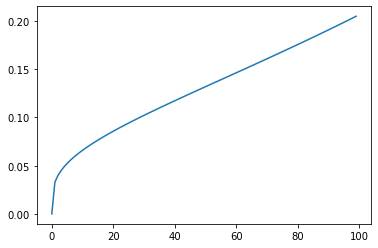

In [188]:
best_parameters, values = ax_client.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **best_parameters))

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



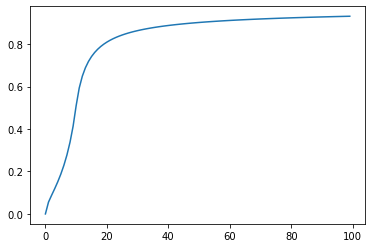

In [52]:
from astrobf.tmo import Mantiuk_Seidel
plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **best_parameters))

In [202]:
ax_client.save_to_json_file("Kmeans_3to7_rescale100.json")

[INFO 04-14 13:25:29] ax.service.ax_client: Saved JSON-serialized state of optimization to `Kmeans_3to7_rescale100.json`.


In [44]:
from ax.utils.notebook.plotting import render, init_notebook_plotting

In [54]:
render(ax_client.get_contour_plot())

[INFO 04-14 00:23:02] ax.service.ax_client: Retrieving contour plot with parameter 'b' on X-axis and 'c' on Y-axis, for metric 'mymetric'. Ramaining parameters are affixed to the middle of their range.


In [55]:
render(ax_client.get_contour_plot(param_x="dl", param_y="dh"))

[INFO 04-14 00:23:17] ax.service.ax_client: Retrieving contour plot with parameter 'dl' on X-axis and 'dh' on Y-axis, for metric 'mymetric'. Ramaining parameters are affixed to the middle of their range.


In [56]:
render(ax_client.get_contour_plot(param_x="b", param_y="dh"))

[INFO 04-14 00:23:19] ax.service.ax_client: Retrieving contour plot with parameter 'b' on X-axis and 'dh' on Y-axis, for metric 'mymetric'. Ramaining parameters are affixed to the middle of their range.


In [58]:
render(ax_client.get_contour_plot(param_x="b", param_y="dl"))

[INFO 04-14 00:24:37] ax.service.ax_client: Retrieving contour plot with parameter 'b' on X-axis and 'dl' on Y-axis, for metric 'mymetric'. Ramaining parameters are affixed to the middle of their range.


In [59]:
render(ax_client.get_contour_plot(param_x="c", param_y="dh"))

[INFO 04-14 00:24:42] ax.service.ax_client: Retrieving contour plot with parameter 'c' on X-axis and 'dh' on Y-axis, for metric 'mymetric'. Ramaining parameters are affixed to the middle of their range.


In [190]:
render(ax_client.get_optimization_trace())

1. Gini만 계산하면 StatMorph 보다 훨씬 빠르게 (metric 하나부터 늘려보기) 
2. min/max는 각 이미지별로. -> fractional 파라미터 
3. Cluster center에 있는 prototype들을 몇 개씩 뽑아서 그들의 TMO 결과가 진화하는걸 눈으로 확인. 기대하는 방향으로 가는가.
4. Center, r20, r80정보 등은 한번만 계산 해놓고 BO iteration 동안에 재활용해도 됨. 

### NOTE

Model performance shows the best result **so far**. It's not supposed to gradually grow every step!. 



In [60]:
ax_client.load_from_json_file("./ax_client_snapshot.json")

[INFO 04-14 01:45:29] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


## Prototypical samples

In [132]:
clustring = best_parameters

result_check = custom_morph.step_simple_morph(all_gals, best_parameters)
add_ttype(result_check, cat)

Is every element matched?:  True


In [ ]:
eval_metrics, clustering = do_ML(result_check, 
                                 fields=['gini', 'm20'], 
                                 return_cluster=True,
                                 cluster_method="ward")

# Cluster
from sklearn.neighbors.nearest_centroid import NearestCentroid

# Get centroid
compact = struct_to_ndarray(select_columns(result_check, fields))
y_pred = clustering.fit_predict(compact)

clf = NearestCentroid()
clf.fit(compact, y_pred)


clu1 = result_check[clustering.labels_.astype(bool)]
clu2 = result_check[~clustering.labels_.astype(bool)]

3970


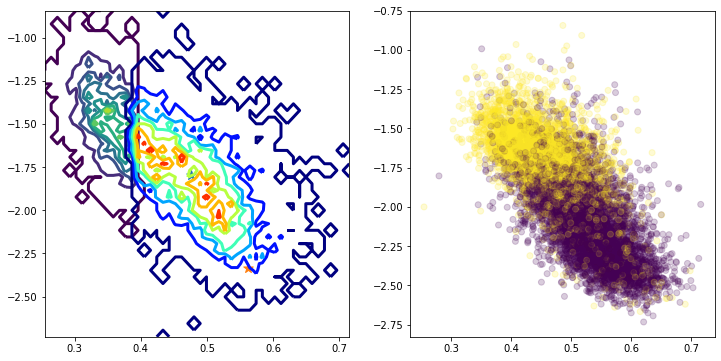

In [177]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,6)
counts, ybins, xbins, _image = ax.hist2d(result_check['gini'],
                                         result_check['m20'],
                                         bins=50,
                                         cmap="gist_gray_r")
counts2, ybins2, xbins2 = np.histogram2d(clu1['gini'], clu1['m20'], 
                                      range=[[ybins.min(), ybins.max()],
                                             [xbins.min(), xbins.max()]], 
                                      bins=50)
axs[0].contour(counts2,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],
           linewidths=3, cmap='viridis')

counts3, ybins3, xbins3 = np.histogram2d(clu2['gini'], clu2['m20'], 
                                      range=[[ybins.min(), ybins.max()],
                                             [xbins.min(), xbins.max()]], 
                                      bins=50)
axs[0].contour(counts3,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],
           linewidths=3, cmap='jet')
for xc, yc in clf.centroids_:
    axs[0].scatter(xc, yc, marker='*', s=100)
#ax.set_aspect("equal")

labels = get_binary_label(result_check, 'ttype', 3, 7)
axs[1].scatter(result_check['gini'], result_check['m20'], c=labels, alpha=0.2)
plt.show()

In [157]:
np.sum(labels)

0